# This notebook takes an area of interest (Cape Cod, MA), queries the Water Quality Portal, removes unwanted points and saves a geoJSON (or shapefile) with points and temperatures

In [1]:
# Import all the required libraries
import os
from io import BytesIO
from zipfile import ZipFile
import requests
import pandas
import numpy
import geopandas
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# All notebook functions
def response_zip_to_df(res):
    """Returns dataframe from zipped csv response
    Note: This can be memory intensive for large results, specify dtypes for read_csv to reduce
    """
    # zipfile object from response content bytes
    archive = ZipFile(BytesIO(res.content))
    item1 = archive.namelist()[0]  # Name of first file
    return pandas.read_csv(archive.open(item1), low_memory=False)


def getBoundingBox(shp):
    """Use geopandas library instead of arcpy
    param@fc should be a shapefile
    """
    if not isinstance(shp, geopandas.geodataframe.GeoDataFrame):
        shp = geopandas.read_file(shp)
    xmin = shp.bounds['minx'][0]
    xmax = shp.bounds['maxx'][0]
    ymin = shp.bounds['miny'][0]
    ymax = shp.bounds['maxy'][0]

    return ','.join(map(str, [xmin, ymin, xmax, ymax]))


def req_str(url, data):
    """Use requests lib to print url server request"""
    return requests.Request('GET', url, params=data).prepare().url


def getWQP(params):
    """Doc string..."""

    # Copy dict to avoid in-place changes
    data = params

    # Pull dataTable from data
    if 'dataTable' in data.keys():
        table = data['dataTable']
        del data['dataTable']
    else:
        table = 'Station'

    # Standard Params
    data['mimeType'] = 'csv'
    data['zip'] = 'yes'

    # Source url
    url = "https://www.waterqualitydata.us/data/{}/search".format(table)

    # Check url status
    if requests.get(url).status_code != 200:
        statusCode = requests.get(url).status_code
        print("{} web service response {}".format(url, statusCode))
    res = requests.get(url, data)
    if not res.ok:
        print("Problem with response from {}".format(req_str(url, data)))
        print(res.headers['Warning'], 1)
        # add break?

    return res


def station_df_to_gdf(df, outEPSG=4269):
    """Params station DataFrame, desired EPSG code
    Returns simplified geodataframe with consistent datum matching EPSG
    Assumes unrecognized or missing crs datum column names are already in outEPSG
    """
    # Dictionary of expected crs
    crsdict = {'NAD27': 4267, 'NAD83': 4269, 'WGS84': 4326, }

    # Filter columns for simplified dataframe
    latCol, lonCol = 'LatitudeMeasure', 'LongitudeMeasure'
    crsCol = 'HorizontalCoordinateReferenceSystemDatumName'
    cols = ['OrganizationIdentifier', 'OrganizationFormalName',
            'MonitoringLocationIdentifier', 'MonitoringLocationTypeName',
            'ProviderName', latCol, lonCol, crsCol]
    df = df.filter(items=cols)

    # Create geodataframe for each station crs
    gdf_list = []
    for crs in set(df[crsCol]):
        sub_df = df[df[crsCol] == crs]  #df subset w/ CRS
        # Create sub-geodataframe
        geom = geopandas.points_from_xy(sub_df[lonCol], sub_df[latCol])
        sub_gdf = geopandas.GeoDataFrame(sub_df, geometry=geom)

        # Set CRS for sub-geodataframe
        if crs in crsdict.keys():
            sub_gdf.set_crs(epsg=crsdict[crs], inplace=True)
            # Transform if necessary
            if crsdict[crs] != outEPSG:
                sub_gdf.to_crs(outEPSG, inplace=True)
        else:
            sub_gdf.set_crs(epsg=outEPSG, inplace=True)

        gdf_list.append(sub_gdf)

    # Assert CRS all match outEPSG (should always)
    for gdf in gdf_list:
        assert gdf.crs.to_epsg() == outEPSG, "Projections don't match"

    if len(gdf_list) > 1:
        # Recombine sub geodataframes
        gdf = geopandas.GeoDataFrame(pandas.concat(gdf_list,
                                                   ignore_index=True))
    else:
        gdf = gdf_list[0]
    # Drop old fields (this could be made optional)
    gdf.drop(columns=[latCol, lonCol, crsCol], inplace=True)

    return gdf


def datetime_combine(df, date_field, time_field, tz_field, datetime_field):
    """from USGS data retrieval (for NWIS)"""
    # Time zone converter dictionary
    tz_dict = {'EST': '-0500',
               'EDT': '-0400',
               numpy.nan: ''}
    df[tz_field] = df[tz_field].map(tz_dict)
    df[time_field] = df[time_field].fillna('00:00:00')

    # datetime formated
    df[datetime_field] = pandas.to_datetime(df.pop(date_field) + ' ' +
                                            df.pop(time_field) + ' ' +
                                            df.pop(tz_field),
                                            format='%Y-%m-%d %H:%M',
                                            utc=True)
    return df


def temp_F_to_C(temp_F):
    """Convert temperture from Fahrenheit to Celsius"""
    return (temp_F - 32.0) * 5.0 / 9.0
# try/except wouldn't work on scalar
#     except ValueError as e:
#         # If non-numeric string return NaN
#         print ('{}, substituted NaN'.format(e))
#         return numpy.nan


def convert_temperature(df, val_field, unit_field, new_field):
    """Convert temperature field to consistent degrees C
    if new_field specified (default) dataframe updated inplace and old fields dropped
    if no new_field specified returns series with converted values
    """
    #val_field dtype should be 'float64', otherwise non-floats -> NaN
    if df[val_field].dtype != numpy.float64:
        df[val_field] = pandas.to_numeric(df[val_field],
                                          downcast="float",
                                          errors='coerce')
    unit_mask = df[unit_field] == 'deg F'
    df[new_field] = df[val_field].mask(unit_mask, temp_F_to_C(df[val_field]))
    df.drop([val_field, unit_field], axis=1, inplace=True)
    # If no new field
    # df[val_field].mask(unit_mask, temp_F_to_C(df[val_field]))

## Part 1: Retrieve Data

Load Area of Interest (AOI) shapefile from temperature_data folder in current working directory.

In [3]:
data_dir = os.path.join(os.getcwd(), 'temperature_data')
# Original source:
shp_aoi = os.path.join(data_dir, 'NewEngland.shp')
gdf_aoi_in = geopandas.read_file(shp_aoi)
gdf_aoi_in.to_crs(epsg=4269, inplace=True)

<IPython.core.display.Javascript object>


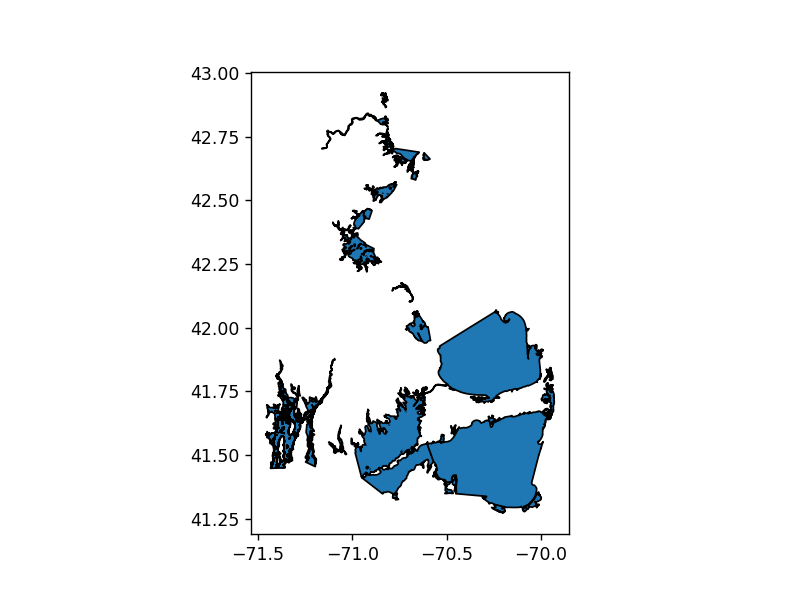

In [4]:
# Must be dissolved into single feature or run one at a time (e.g. by state)
gdf_aoi = gdf_aoi_in.dissolve(by='RSRC_CLASS', aggfunc='sum')
gdf_aoi.plot(edgecolor='k')

Build WQP query for water temperature

In [5]:
query = {'characteristicName': 'Temperature, water'}
# CRS for WQP Datum must be NAD83 and linear unit decimal degrees
gdf_aoi.to_crs(epsg=4269, inplace=True)
#curent = 4269, query =? NAD83, assert gdf_aoi.crs.datum?
# Bounding box
query['bBox'] = getBoundingBox(gdf_aoi)

Run query and create geodataframe from query response

In [6]:
response = getWQP(query)
station_df = response_zip_to_df(response)

https://www.waterqualitydata.us/data/Station/search web service response 400


In [7]:
stations_gdf = station_df_to_gdf(station_df)
print('Number of stations in extent: {}'.format(len(stations_gdf)))

Number of stations in extent: 4322


Clip geodataframe to original Area Of Interest (AOI)

In [8]:
# Change Coordinate Reference System to match AOI if it doesn't already
if stations_gdf.crs != gdf_aoi.crs:
    stations_gdf.to_crs(gdf_aoi.crs.to_epsg(), inplace=True)
# Sample points are retrieved by extent, so clip it to the AOI
stations_aoi_gdf = geopandas.clip(stations_gdf, gdf_aoi_in)
print('Number of stations in AOI: {}'.format(len(stations_aoi_gdf)))

Number of stations in AOI: 981


Run query for results and create dataframe from response

In [9]:
query['dataTable'] = 'Result'
query['dataProfile'] = 'narrowResult'

In [10]:
# This is a big request and may be slow
response = getWQP(query)

https://www.waterqualitydata.us/data/Result/search web service response 400


In [11]:
results_df = response_zip_to_df(response)

Drop empty and duplicate fields from dataframe

In [12]:
results_df.dropna(axis=1, how='all', inplace=True)
results_df.drop(columns=['OrganizationIdentifier',
                         'OrganizationFormalName',
                         'ProviderName'],
                inplace=True)

In [13]:
print('Number of temperature results in extent: {}'.format(len(results_df)))

Number of temperature results in extent: 85904


Join station points and temperature results on 'MonitoringLocationIdentifier'

In [14]:
loc_ID = 'MonitoringLocationIdentifier'
results_gdf = stations_aoi_gdf.set_index(loc_ID).join(results_df.set_index(loc_ID))
# Note: should match number of stations in AOI
print('Sample sites with results in AOI: {}'.format(len(set(results_gdf.index))))

Sample sites with results in AOI: 981


In [15]:
print('Number of temperature results in AOI: {}'.format(len(results_gdf)))

Number of temperature results in AOI: 9146


<IPython.core.display.Javascript object>


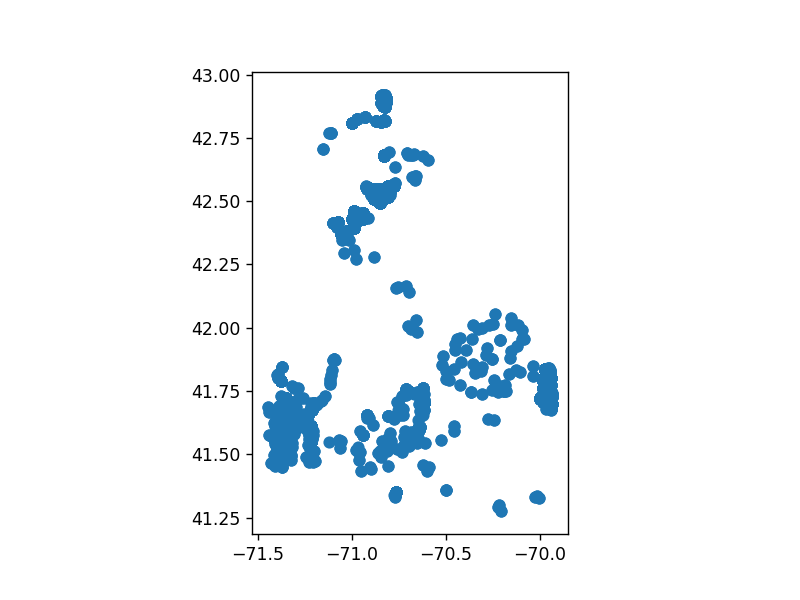

In [16]:
results_gdf.plot()

Convert temperature results to consistent units

In [17]:
convert_temperature(results_gdf,
                    'ResultMeasureValue',
                    'ResultMeasure/MeasureUnitCode',
                    'deg_c')
results_gdf.reset_index(inplace=True)

## Part 2: Drop unwanted results

Drop NaN and outliers (>100 C)

In [18]:
# Create dataframe of outliers to inspect
outliers = results_gdf[results_gdf['deg_c'] >= 100]
# Count NaNs
null_results = results_gdf[results_gdf['deg_c'].isnull()]
# Drop outliers from results data frame (also drops NaN)
clean_gdf = results_gdf[results_gdf['deg_c'] < 100]
# Display dropped 
outliers.head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,ProviderName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,...,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,deg_c


In [19]:
print('Removed {} nulls and {} outliers'
      .format(len(null_results), len(outliers)))

Removed 53 nulls and 0 outliers


Identify and drop any temperature from a depth >=5 m

In [20]:
# All units are currently in m (new data may require conversion)
depth_col = 'ResultDepthHeightMeasure/MeasureValue'
non_surface = results_gdf[results_gdf[depth_col] >= 5]
# Drop non-surface results from results data frame
clean_gdf = clean_gdf[~(clean_gdf[depth_col] >= 5)]
# Display dropped
non_surface.head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,ProviderName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,...,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,deg_c
8614,"NALMS-C41.575,-70.9417",NALMS,North American Lake Management Society,Estuary,STORET,POINT (-70.94170 41.57500),NALMS-37414_WATER_QUALITY,2006-06-26,07:55:00,EST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
8615,"NALMS-C41.575,-70.9417",NALMS,North American Lake Management Society,Estuary,STORET,POINT (-70.94170 41.57500),NALMS-37416_WATER_QUALITY,2006-07-10,08:16:00,EST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0


In [21]:
print('{} non-surface results'.format(len(non_surface)))

2 non-surface results


Identify and drop duplicate temperatures at the same location and time

In [22]:
# Create dataframe of duplicate temperatures at the same location and time
# Total 205,207 vs duplicates 27,816 = ~13.6% -> w/ loc_id 27,756 = ~13.5% ()
duplicates = clean_gdf[clean_gdf[['geometry',
                                      'ActivityStartDate',
                                      'ActivityStartTime/Time',
                                      'deg_c']]
                         .duplicated(keep=False)].sort_values(by=['deg_c'])
print('Number of duplicates (all copies): {}'.format(len(duplicates)))

Number of duplicates (all copies): 1064


Only the first result of a duplicate result pair was retained. Further analysis of duplicates could help identify the higher quality result (e.g. multiple readings using different methods) or the underlying cause of those duplicates (e.g. an update/error in location ID, the same data loaded by multiple organozations, etc.).

In [23]:
duplicates.head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,ProviderName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,...,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,deg_c
2368,11NPSWRD_WQX-SAIR_ACE_SRPR_A,11NPSWRD_WQX,National Park Service Water Resources Division,River/Stream,STORET,POINT (-70.96849 42.44411),11NPSWRD_WQX-SAIR_ACE_SRPR_A_19840202_112903,1984-02-02,NaN,NaN,...,11NPSWRD_WQX,Unknown or Unspecified Procedure,NaN,NaN,1984-02-02,0001-01-01 00:00:00,EST,NaN,NaN,-1.2
2361,11NPSWRD_WQX-SAIR_ACE_SRPR_A,11NPSWRD_WQX,National Park Service Water Resources Division,River/Stream,STORET,POINT (-70.96849 42.44411),11NPSWRD_WQX-SAIR_ACE_SRPR_A_19840202_112901,1984-02-02,NaN,NaN,...,11NPSWRD_WQX,Unknown or Unspecified Procedure,NaN,NaN,1984-02-02,0001-01-01 00:00:00,EST,NaN,NaN,-1.2
2263,11NPSWRD_WQX-SAIR_ACE_SRGE_B,11NPSWRD_WQX,National Park Service Water Resources Division,River/Stream,STORET,POINT (-70.97562 42.44878),11NPSWRD_WQX-SAIR_ACE_SRGE_B_19840202_113023,1984-02-02,NaN,NaN,...,11NPSWRD_WQX,Unknown or Unspecified Procedure,NaN,NaN,1984-02-02,0001-01-01 00:00:00,EST,NaN,NaN,-1.2
2273,11NPSWRD_WQX-SAIR_ACE_SRGE_B,11NPSWRD_WQX,National Park Service Water Resources Division,River/Stream,STORET,POINT (-70.97562 42.44878),11NPSWRD_WQX-SAIR_ACE_SRGE_B_19840202_113025,1984-02-02,NaN,NaN,...,11NPSWRD_WQX,Unknown or Unspecified Procedure,NaN,NaN,1984-02-02,0001-01-01 00:00:00,EST,NaN,NaN,-1.2
6054,AQUINNAH-MEN PND DOD,AQUINNAH,Wampanoag Tribe of Gay Head (Aquinnah) - Massa...,Estuary,STORET,POINT (-70.76667 41.35005),AQUINNAH-DOD-D4132005-MEN PND DOD-0,2005-04-13,00:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [24]:
# Ultimately we choose to drop duplicates even if they had different loc_ID
# (n=12, or six pairs of loc_ID where a geometry&time&value matched)
duplicates2 = clean_gdf[clean_gdf[['geometry',
                                 loc_ID,
                                 'ActivityStartDate',
                                 'ActivityStartTime/Time',
                                 'deg_c']]
                    .duplicated(keep=False)].sort_values(by=['deg_c'])
df_all = duplicates.merge(duplicates2,  
                   how='left', indicator=True)
# Duplicates w/ non-matching loc_ID (12 loc_IDs)
loc_ID_mismatch = df_all[df_all['_merge'] == 'left_only']
unique = set(loc_ID_mismatch[loc_ID])
print('{} duplicates with the same {}'
      .format(len(duplicates) - len(duplicates2), loc_ID))

34 duplicates with the same MonitoringLocationIdentifier


In [25]:
for loc in unique:
    dups = len(duplicates[duplicates[loc_ID] == loc])
    results = len(clean_gdf[clean_gdf[loc_ID] == loc])
    print('{} duplicates of {} results at {}'.format(dups, results, loc))

6 duplicates of 108 results at AQUINNAH_WQX-MEN PERI #P8
5 duplicates of 108 results at AQUINNAH_WQX-MEN PERI #P5
4 duplicates of 107 results at AQUINNAH_WQX-MEN PERI #P3
4 duplicates of 100 results at AQUINNAH_WQX-MEN PERI #P2
2 duplicates of 105 results at AQUINNAH_WQX-MEN PERI #P7
5 duplicates of 105 results at AQUINNAH_WQX-MEN PERI #P6
4 duplicates of 106 results at AQUINNAH_WQX-MEN PERI #P1
4 duplicates of 108 results at AQUINNAH_WQX-MEN PERI #P4


In [26]:
for org in set(duplicates.OrganizationFormalName):
    print('{}: {} duplicates of {} results'
          .format(org,
                  len(duplicates[duplicates.OrganizationFormalName == org]),
                  len(clean_gdf[clean_gdf.OrganizationFormalName == org]),
                 ))

Wampanoag Tribe of Gay Head (Aquinnah): 34 duplicates of 847 results
Mystic River Watershed Association (Massachusetts): 54 duplicates of 354 results
North American Lake Management Society: 42 duplicates of 127 results
National Park Service Water Resources Division: 710 duplicates of 5750 results
Environmental Monitoring and Assessment Program: 94 duplicates of 774 results
Wampanoag Tribe of Gay Head (Aquinnah) - Massachusetts: 126 duplicates of 158 results
Massachusetts Department of Environmental Protection (MassDEP): 4 duplicates of 23 results


Drop the duplicates

In [27]:
count1 = len(clean_gdf)
clean_gdf = clean_gdf.drop_duplicates(subset=['geometry',
                                              'ActivityStartDate',
                                              'ActivityStartTime/Time',
                                              'deg_c'])
print('Dropped {} duplicate results'.format(count1 - len(clean_gdf)))

Dropped 624 duplicate results


## Part 3: Save result as (1) shapefile with required field re-naming, or (2) geoJSON with datetime field and original field name (used in Tampa_H3Temperature notebook)

In [28]:
# Note: ESRI shapefiles support date but not datetime
# Rename fields to shorten for shapefile
rename_dict = {'OrganizationIdentifier': 'Org_ID',
               'OrganizationFormalName': 'Org_Name',
               'MonitoringLocationTypeName': 'Loc_Type',
               'ProviderName': 'Provider',
               'ActivityIdentifier': 'ActivityID',
               'ActivityStartDate': 'ActivityDa',
               'ActivityStartTime/Time': 'ActivityTi',
               'ActivityStartTime/TimeZoneCode': 'ActivityTZ',
               'ResultIdentifier': 'Result_ID',
               'ResultDepthHeightMeasure/MeasureValue': 'Depth',
               'ResultDepthHeightMeasure/MeasureUnitCode': 'DepthUnit',
               'AnalysisStartDate': 'AnalysisDa',
               'AnalysisStartTime/Time': 'AnalysisTi',
               'AnalysisStartTime/TimeZoneCode': 'AnalysisTZ',
               'ResultAnalyticalMethod/MethodIdentifier': 'AnalysisID',
               'ResultAnalyticalMethod/MethodIdentifierContext': 'AnalysisCo',
               'ResultAnalyticalMethod/MethodName': 'AnalysisNa',
               'ResultDetectionConditionText': 'DetectText',
               'ResultDetectionQuantitationLimitUrl': 'DetectURL',
              }
#TODO: index rename doesn't work, try reset index first (may muck up later steps)
results_gdf_shp = clean_gdf.rename(columns=rename_dict,
                                     index={clean_gdf.index.name: 'Loc_ID'})
out_shp = os.path.join(data_dir, 'AOI_Temperature_Results.shp')
results_gdf_shp.to_file(out_shp)

In [29]:
# Parse activity to datetime
clean_gdf = datetime_combine(clean_gdf,
                               'ActivityStartDate',
                               'ActivityStartTime/Time',
                               'ActivityStartTime/TimeZoneCode',
                               'Activity_datetime')
# Drop '0001-01-01' from analysis time stamps
analysis = 'AnalysisStartTime/Time'
clean_gdf[analysis] = [t[11:] if str(t).startswith('0001-01-01') else t
                         for t in clean_gdf[analysis]]
clean_gdf = datetime_combine(clean_gdf,
                               'AnalysisStartDate',
                               'AnalysisStartTime/Time',
                               'AnalysisStartTime/TimeZoneCode',
                               'Analysis_datetime')
out_geojson = os.path.join(data_dir, 'AOI_Temperature_Results_DT.geojson')
clean_gdf.to_file(out_geojson, driver='GeoJSON', date_format='iso')

Map number of samples and mean temperature

<IPython.core.display.Javascript object>


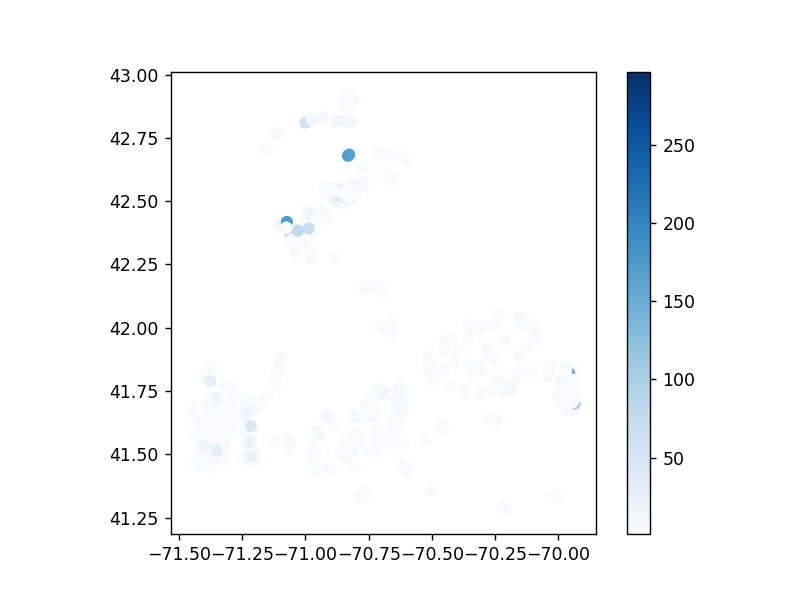

In [30]:
result_counts = clean_gdf.set_index(loc_ID).groupby(level=0).count()
# Drop columns in both tables from result_counts
drop_cols = [col for col in result_counts.columns if col in stations_aoi_gdf.columns]
result_counts.drop(columns=drop_cols, inplace=True)
result_counts = result_counts.join(stations_aoi_gdf.set_index(loc_ID))
result_counts.plot(column='deg_c', cmap='Blues', legend=True)

In [31]:
count_temp = result_counts['deg_c']
print('Range: {} to {} \n Mean: {}'.format(count_temp.min(),
                                           count_temp.max(),
                                           count_temp.mean()))

Range: 1 to 297 
 Mean: 8.728865979381442


<IPython.core.display.Javascript object>


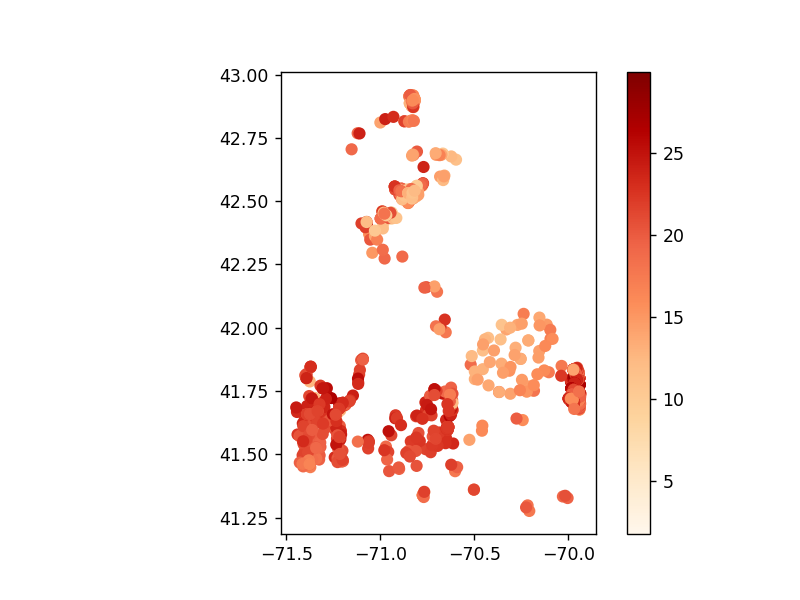

In [32]:
result_mean = clean_gdf.set_index(loc_ID).groupby(level=0).mean()
result_mean = stations_aoi_gdf.set_index(loc_ID).join(result_mean)
result_mean.plot(column='deg_c', cmap='OrRd', legend=True)

In [33]:
mean_temp = result_mean['deg_c']
print('Range: {} to {}\n Mean: {}'.format(mean_temp.min(),
                                          mean_temp.max(),
                                          mean_temp.mean()))

Range: 1.7844444513320923 to 29.959999084472656
 Mean: 19.470897674560547
